In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4647,24-11-2023,28.8304
4648,27-11-2023,28.8607
4649,28-11-2023,28.9104
4650,29-11-2023,28.9289


In [4]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [5]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


In [6]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [7]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


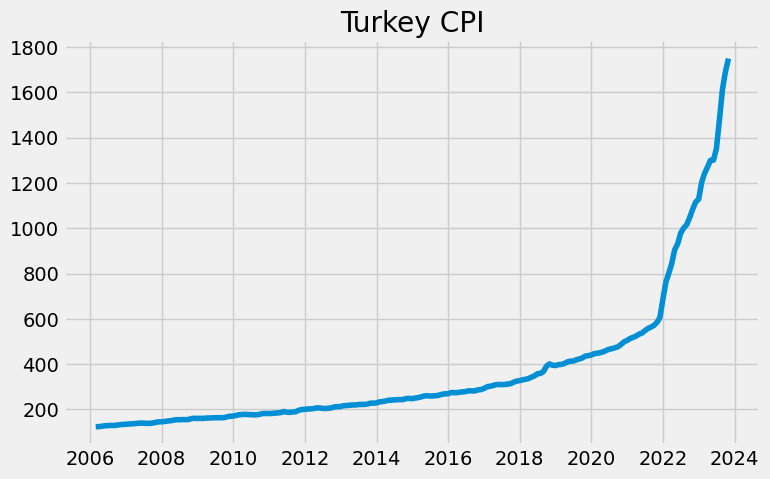

In [8]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [9]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [10]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637895


In [11]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933903


In [12]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-10-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-05-31,9.5
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.2


In [13]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4639,14-11-2023,84.20
4640,15-11-2023,82.40
4641,16-11-2023,77.73
4642,17-11-2023,81.22


In [14]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle


brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381


In [15]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-07-31,80.355500
2023-08-31,85.104348
2023-09-30,92.766499


In [16]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10


In [17]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503


In [18]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503


In [19]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
209,2023-7,17.50
210,2023-8,23.50
211,2023-9,31.00
212,2023-10,33.00


In [20]:
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-07-31,17.50
2023-08-31,23.50
2023-09-30,31.00


In [21]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500
2023-10-31,59.3925


In [22]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100) (2).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-10-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-05-31,181.176925,179.718446,179.734862
2023-06-30,180.070938,186.170934,179.520633
2023-07-31,191.652101,194.140963,184.782561
2023-08-31,184.907520,183.148681,176.126980


In [23]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-12-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [24]:
sanayi=pd.read_excel("C:/Users/Bora/Downloads/sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-05-31,146.666835
2023-06-30,148.351267
2023-07-31,147.798299
2023-08-31,146.674452


In [25]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-12-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560
2023-10-31,43.8925


In [26]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-12-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57


In [27]:
borc=evds.get_data(["TP.KB.GEN35"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",end="2023-11-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,1965374.0
2006-02-28,-2689921.0
2006-03-31,-1035119.0
2006-04-30,-2915022.0
2006-05-31,4160085.0
...,...
2023-06-30,-215385487.0
2023-07-31,40844172.0
2023-08-31,67920592.0
2023-09-30,-133551243.0


In [28]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-06-30,87.02
2023-07-31,81.68
2023-08-31,85.52
2023-09-30,89.55


In [29]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-06-30,51.56
2023-07-31,48.68
2023-08-31,52.39
2023-09-30,55.46


In [30]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USD/TL,ParaArzi,Motorin,Perakende Satış,Sanayi,Kredi,M3,REDK,REDKT,TÜFE
Tarih,,,,,,,,,,
2011-04-30,-0.810542,1.738088,-1.218711,-0.176965,-0.162949,2.978727,1.642254,1.593625,2.284537,0.866270
2011-05-31,-0.399628,0.113812,-1.660706,1.110822,1.016932,3.568114,0.477281,-3.090570,-1.121135,2.420827
2011-06-30,0.415548,2.361933,2.055258,2.490629,1.895703,3.122424,2.450559,-1.878794,-3.463549,-1.430743
2011-07-31,2.804715,2.187652,2.237631,1.258223,1.925345,2.898935,2.189939,-3.289474,-3.817214,-0.409400
2011-08-31,3.747733,0.569285,1.664460,-0.296514,2.983648,3.279260,0.444077,-4.213626,-5.533295,0.726069
...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.931099,-0.372743,5.675617,15.439600,-6.136520,-5.585725,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.684198,-0.760392,1.850455,5.968276,4.701273,7.621200,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.712124,-0.125062,2.080815,4.845313,4.712348,5.859897,4.753114


In [31]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
data["Borç"]=borc["Borç"].shift(1)
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data=data.dropna(axis=0)
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','Şok','REDK','REDKT','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Şok,REDK,REDKT,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,3.604096,0.82,3.375162,-18000128.0,3.267877,9.0220,1,-3.691204,-5.094658,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-0.850238,0.73,1.804994,2670214.0,1.451593,10.6275,0,2.179150,0.919060,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,0.128936,0.80,0.451349,-718995.0,0.341852,11.3125,1,0.471546,0.641623,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-0.863760,0.73,0.796760,-4527090.0,0.129671,11.0200,1,4.682667,5.892031,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,-1.367417,0.80,-0.362357,-1170192.0,0.468727,10.4940,0,1.283880,2.058652,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.507585,-7.526882,3.200118,32.0225,0.00,1.434427,7.37,4.931112,-123320822.0,3.535416,31.4625,0,1.004595,-1.762413,4.796282,9.5,9.09,0.043076
2023-06-30,7.066073,16.807611,-0.119192,38.5600,0.00,1.148476,7.55,-1.017069,119806780.0,5.711697,39.5920,0,-7.925087,-11.057444,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.931099,45.8250,34.00,-0.372743,7.70,15.146856,-215385487.0,5.675617,33.1250,1,-6.136520,-5.585725,15.439600,9.3,17.50,9.488824


In [32]:
data.to_csv("data.csv")

In [35]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=data.iloc[:,:-1].columns
train=data.iloc[:-3,:]
test=data.iloc[-3:,:]
X_train,X_test,y_train,y_test=train.iloc[:,:-1],test.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,-1]
best_mse=float("inf")
best_features=[]
for r in range(8,12):
   for combo in combinations(features, r):
        selected_features = list(combo)
        
          
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train_subset, y_train)
        y_pred=krr.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfeatures=data.iloc[:,:-1].columns\ntrain=data.iloc[:-3,:]\ntest=data.iloc[-3:,:]\nX_train,X_test,y_train,y_test=train.iloc[:,:-1],test.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,-1]\nbest_mse=float("inf")\nbest_features=[]\nfor r in range(8,12):\n   for combo in combinations(features, r):\n        selected_features = list(combo)\n        \n          \n        X_train_subset = X_train[selected_features]\n        X_test_subset = X_test[selected_features]\n        krr = KernelRidge(alpha=1.0)\n        krr.fit(X_train_subset, y_train)\n        y_pred=krr.predict(X_test_subset)\n        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))\n        \n\n        \n        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin\n        if rmse1 < best_mse:\n            best_mse = rmse1\n            best_features = s

In [36]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Sanayi', 'Enflasyon Belirsizliği', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X = sm.add_constant(X)
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model = sm.OLS(y, X).fit()
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [37]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [38]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Sanayi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [39]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [40]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'ParaArzi', 'Kredi', 'Şok', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [41]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [42]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [43]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Lars Regression,0.072823
Linear Regression,0.080919
SGD Regressor,0.228209
Lasso Regression,0.237855
Gaussian Regression,0.700413
Bayesian Regression,0.775546
Kernel Regression,0.827823


<Figure size 500x1000 with 0 Axes>

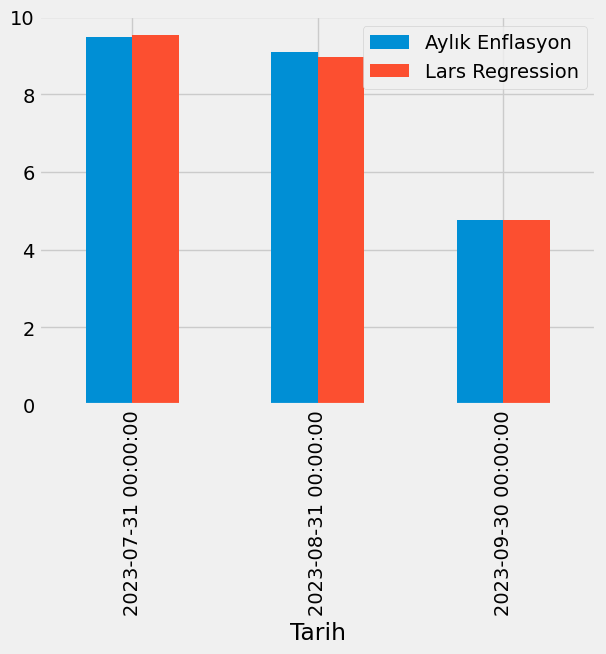

In [44]:
plt.figure(figsize=(5,10))
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Lars Regression"]].plot(kind="bar")
plt.show()

In [45]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,58.050804
2024-01-31,58.243736
2024-02-29,58.551302
2024-03-31,59.409785
2024-04-30,60.386403
2024-05-31,60.370085


In [46]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.7920
2010-02-28,13.5200
2010-03-31,13.5125
2010-04-30,13.0040
2010-05-31,13.1525
...,...
2023-05-31,32.0225
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650


In [47]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,58.050804
2024-01-31,58.243736
2024-02-29,58.551302
2024-03-31,59.409785
2024-04-30,60.386403
2024-05-31,60.370085
2024-06-30,61.813906
2024-07-31,62.228177


In [48]:
mfaiz[189:]

,Mevduat Faizi
2021-11-30,16.2025
2021-12-31,17.4400
2022-01-31,19.2675
2022-02-28,18.1100
2022-03-31,17.1350
2022-04-30,17.0840
2022-05-31,16.9900
2022-06-30,18.2250
2022-07-31,19.7920
2022-08-31,19.2050


In [153]:
model=auto_arima(mfaiz["Mevduat Faizi"][189:],trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(25))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-1,0]},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2023-11-30,45.667500
2023-12-31,46.895208
2024-01-31,48.122917
2024-02-29,49.350625
2024-03-31,50.578333
2024-04-30,51.806042
2024-05-31,53.033750
2024-06-30,54.261458
2024-07-31,55.489167
2024-08-31,56.716875


In [50]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [51]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-07-31,1991.867401
2023-08-31,2275.241982
2023-09-30,2504.165548
2023-10-31,2432.069312


In [52]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,45
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [53]:
model=auto_arima(pfaiz["Politika Faizi"][144:],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(26)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin

,Politika Faizi
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,33.000000
2023-11-30,41.090000
2023-12-31,43.457272
2024-01-31,44.662083
2024-02-29,46.165240
2024-03-31,46.004222
2024-04-30,45.843766
2024-05-31,45.683869


In [54]:
faiztahmin.columns=["Faiz"]


In [55]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [56]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [57]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [58]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-10-31,9.086846
2023-11-30,9.020789
2023-12-31,9.037068
2024-01-31,9.070009
2024-02-29,9.105404
2024-03-31,9.162471
2024-04-30,9.217564
2024-05-31,9.272508
2024-06-30,9.325146
2024-07-31,9.375390


In [59]:
from prophet import Prophet


In [60]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'm':trial.suggest_int('m',10,200)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6[params["m"]:-12].index
    sn["y"]=df6[params["m"]:-12].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth="linear")
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df6[-12:].values,predictions["yhat"][-12:].values)
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'m\':trial.suggest_int(\'m\',10,200)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6[params["m"]:-12].index\n    sn["y"]=df6[params["m"]:-12].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth="linear")\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=12,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(df6[-12:].values,predictions["yhat"][-12:].values)\n    return mae_score\nstudy = optuna.crea

In [61]:
sn=pd.DataFrame()
sn["ds"]=df6[50:].index
sn["y"]=df6[50:].values
sn["cap"]=80
prophet=Prophet(growth="logistic",changepoint_prior_scale=4.824871754400055,changepoint_range=0.8753050513666666)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=80
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:49 - cmdstanpy - INFO - Chain [1] start processing
22:25:49 - cmdstanpy - INFO - Chain [1] done processing


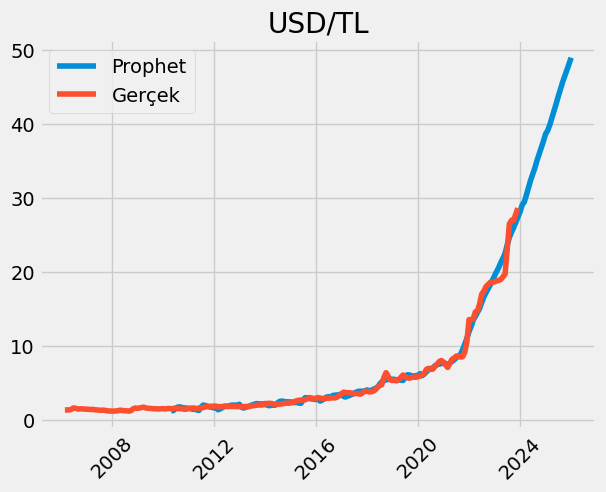

In [62]:
plt.title("USD/TL")
plt.plot(predictions["yhat"],label="Prophet")
plt.plot(df6["USD/TL"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [63]:
usdtahmin=(predictions["yhat"][-26:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2023-12-31    2.618616
2024-01-31    3.385491
2024-02-29    1.289328
2024-03-31    3.204627
2024-04-30    3.270078
2024-05-31    3.276131
2024-06-30    2.570938
2024-07-31    2.493512
2024-08-31    3.013456
2024-09-30    2.436460
2024-10-31    2.417390
2024-11-30    2.315552
2024-12-31    2.627752
2025-01-31    1.236299
2025-02-28    1.814793
2025-03-31    2.411992
2025-04-30    2.308144
2025-05-31    2.341433
2025-06-30    2.320132
2025-07-31    2.183823
2025-08-31    2.155905
2025-09-30    1.759226
2025-10-31    1.783242
2025-11-30    1.709529
2025-12-31    1.841092
Name: yhat, dtype: float64

In [64]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-4:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", end="2026-01-27", freq="1M"))
usdtahmin1

,USD/TL
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.386977
2024-01-31,30.381870
2024-02-29,30.773592
2024-03-31,31.759771
2024-04-30,32.798340
2024-05-31,33.872857


In [65]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[100:].index
    sn["y"]=df14[100:].values
    sn["cap"]=1000
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=1000
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[100:].index\n    sn["y"]=df14[100:].values\n    sn["cap"]=1000\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=1000\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [66]:
#study.best_params

In [67]:
sn=pd.DataFrame()
sn["ds"]=df14[100:].index
sn["y"]=df14[100:].values
sn["cap"]=500
prophet=Prophet(growth="linear",changepoint_prior_scale=4.999468721964881,changepoint_range=0.8755786334851338)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=500
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:50 - cmdstanpy - INFO - Chain [1] start processing
22:25:50 - cmdstanpy - INFO - Chain [1] done processing


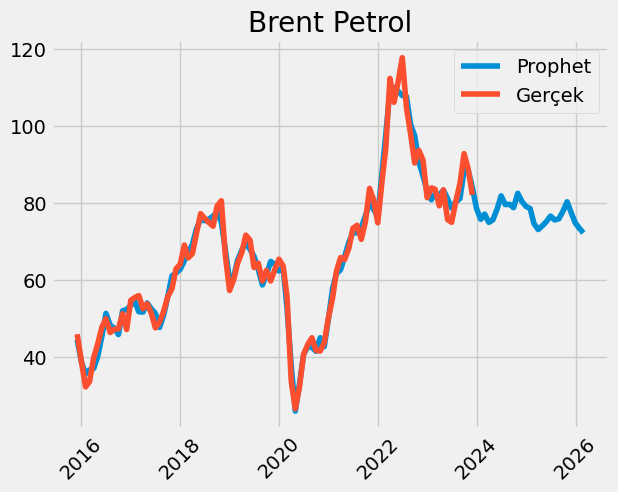

In [68]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"],label="Prophet")
plt.plot(df14["Brent"][100:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [69]:
brenttahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
brenttahmin

ds
2023-12-31   -6.487732
2024-01-31   -3.611233
2024-02-29    1.806042
2024-03-31   -2.791922
2024-04-30    0.879429
2024-05-31    3.673310
2024-06-30    4.393660
2024-07-31   -2.765757
2024-08-31    0.084033
2024-09-30   -1.084712
2024-10-31    4.734090
2024-11-30   -2.540235
2024-12-31   -1.630944
2025-01-31   -0.736628
2025-02-28   -4.957420
2025-03-31   -2.049326
2025-04-30    1.274064
2025-05-31    1.544646
2025-06-30    1.895376
2025-07-31   -1.334577
2025-08-31    0.423206
2025-09-30    2.563433
2025-10-31    3.158016
2025-11-30   -3.511536
2025-12-31   -3.492697
2026-01-31   -1.866403
2026-02-28   -1.605611
Name: yhat, dtype: float64

In [70]:
brenttahmin1 = []
result = df14.iloc[-1,0]
for i in range(len(brenttahmin)):
    result *= (1 + brenttahmin[i] / 100)
    brenttahmin1.append(result)

brenttahmin1 = np.array(brenttahmin1).reshape(-1, 1)
brenttahmin1 = pd.DataFrame(brenttahmin1)
brenttahmin1.columns = ["Brent"]
brenttahmin1 = brenttahmin1.set_index(pd.date_range(start="2023-12-30", end="2026-03-27", freq="1M"))
row=pd.DataFrame({"Brent":df14.iloc[-2:,0]},index=pd.date_range("2023-10-30",periods=2,freq="1M"))
brenttahmin1=pd.concat([row,brenttahmin1],axis=0)
brenttahmin1

,Brent
2023-10-31,88.704091
2023-11-30,82.056190
2023-12-31,76.732605
2024-01-31,73.961611
2024-02-29,75.297389
2024-03-31,73.195145
2024-04-30,73.838844
2024-05-31,76.551173
2024-06-30,79.914572
2024-07-31,77.704329


In [71]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [72]:
#study.best_params

In [73]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=4.9990034924644275,changepoint_range=0.899334568997575,growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing


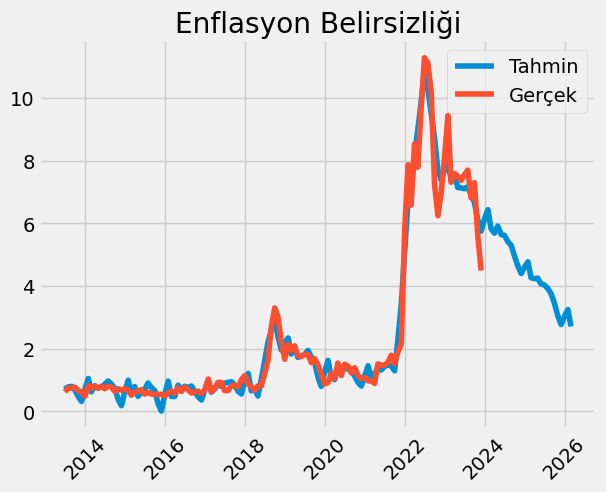

In [74]:
plt.title("Enflasyon Belirsizliği")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(enf_belirsizlik["Enflasyon Belirsizliği"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [75]:
enfbelirsizliktahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
enfbelirsizliktahmin

ds
2023-12-31     6.953347
2024-01-31     4.726997
2024-02-29    -9.552151
2024-03-31    -2.312712
2024-04-30     4.034606
2024-05-31    -4.604811
2024-06-30    -0.478931
2024-07-31    -3.538186
2024-08-31    -2.265246
2024-09-30    -6.425931
2024-10-31    -6.548229
2024-11-30    -5.019494
2024-12-31     4.654556
2025-01-31     3.666030
2025-02-28   -10.624290
2025-03-31    -0.724876
2025-04-30     0.362321
2025-05-31    -4.422187
2025-06-30    -0.710613
2025-07-31    -2.719679
2025-08-31    -4.438113
2025-09-30    -8.031677
2025-10-31   -11.645712
2025-11-30    -9.110944
2025-12-31     9.693603
2026-01-31     6.928056
2026-02-28   -16.593937
Name: yhat, dtype: float64

In [76]:
enfbelirsizliktahmin1 = []
result = enf_belirsizlik.iloc[-1,0]
for i in range(len(enfbelirsizliktahmin)):
    result *= (1 + enfbelirsizliktahmin[i] / 100)
    enfbelirsizliktahmin1.append(result)

enfbelirsizliktahmin1 = np.array(enfbelirsizliktahmin1).reshape(-1, 1)
enfbelirsizliktahmin1 = pd.DataFrame(enfbelirsizliktahmin1)
enfbelirsizliktahmin1.columns = ["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1 = enfbelirsizliktahmin1.set_index(pd.date_range(start="2023-12-30", end="2026-03-27", freq="1M"))
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
enfbelirsizliktahmin1=pd.concat([row,enfbelirsizliktahmin1],axis=0)
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
2023-10-31,5.570000
2023-11-30,4.490000
2023-12-31,4.802205
2024-01-31,5.029205
2024-02-29,4.548808
2024-03-31,4.443607
2024-04-30,4.622889
2024-05-31,4.410014
2024-06-30,4.388893
2024-07-31,4.233606


In [77]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=51,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].index\n    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=51,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nst

In [78]:
#study.best_params

In [79]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][100:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][100:].values
sn["cap"]=1000
prophet=Prophet(changepoint_prior_scale=4.9993655900615845,changepoint_range=0.8731420056547374,growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=1000
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:52 - cmdstanpy - INFO - Chain [1] start processing
22:25:52 - cmdstanpy - INFO - Chain [1] done processing


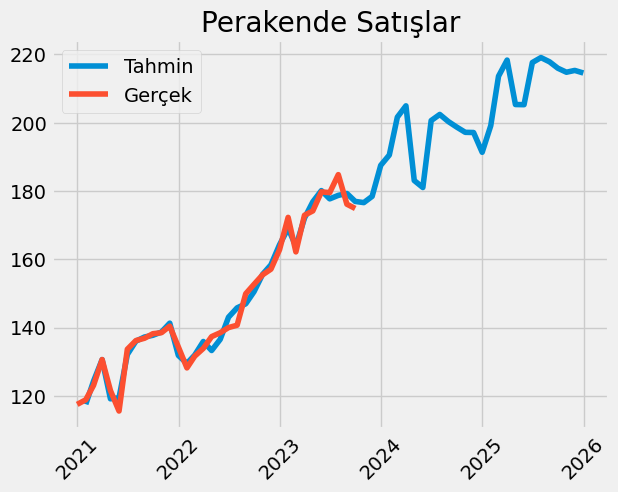

In [80]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-60:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][131:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [81]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2023-10-31    -0.198150
2023-11-30     1.033406
2023-12-31     5.092513
2024-01-31     1.614187
2024-02-29     5.821133
2024-03-31     1.644104
2024-04-30   -10.673696
2024-05-31    -1.121014
2024-06-30    10.832184
2024-07-31     0.895907
2024-08-31    -1.028484
2024-09-30    -0.804435
2024-10-31    -0.776320
2024-11-30    -0.028461
2024-12-31    -2.934550
2025-01-31     4.074081
2025-02-28     7.271980
2025-03-31     2.211173
2025-04-30    -5.961543
2025-05-31    -0.023782
2025-06-30     6.015436
2025-07-31     0.667099
2025-08-31    -0.566781
2025-09-30    -0.861429
2025-10-31    -0.543977
2025-11-30     0.246907
2025-12-31    -0.349946
Name: yhat, dtype: float64

In [82]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-2].pct_change(periods=1)*100).dropna())/100)).values)
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-11-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-4.039005
2024-01-31,-0.348001
2024-02-29,3.118655
2024-03-31,0.323235
2024-04-30,4.178264
2024-05-31,7.069784
2024-06-30,7.077557
2024-07-31,-0.341210
2024-08-31,3.100021


In [83]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=51,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=51,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [84]:
#study.best_params

In [85]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=4.465458778605585,
 changepoint_range=0.8996787920607507,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:53 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing


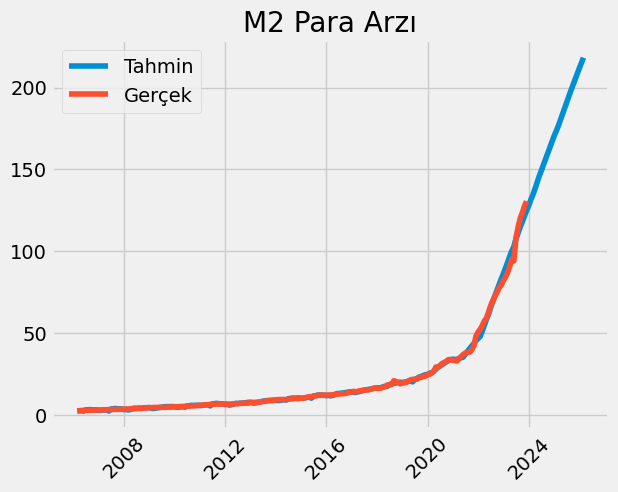

In [86]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(money["Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [87]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(30)
paraarzitahmin

ds
2023-09-30    2.742927
2023-10-31    2.940250
2023-11-30    2.726425
2023-12-31    2.435868
2024-01-31    2.899538
2024-02-29    2.177861
2024-03-31    2.761391
2024-04-30    2.752941
2024-05-31    2.824177
2024-06-30    2.229595
2024-07-31    2.454751
2024-08-31    2.258201
2024-09-30    2.225370
2024-10-31    2.226802
2024-11-30    2.154542
2024-12-31    2.101143
2025-01-31    1.773219
2025-02-28    1.700967
2025-03-31    2.101302
2025-04-30    2.026967
2025-05-31    1.966452
2025-06-30    1.982971
2025-07-31    1.901343
2025-08-31    1.827956
2025-09-30    1.701544
2025-10-31    1.750731
2025-11-30    1.682076
2025-12-31    1.604009
2026-01-31    1.531496
2026-02-28    1.445728
Name: yhat, dtype: float64

In [88]:
paraarzitahmin1 = []
result = money.iloc[-4,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2023-09-30", end="2026-03-27", freq="1M"))
paraarzitahmin1.iloc[:2,0]=money.iloc[-3:-1,0]
paraarzitahmin1

,Para Arzi
2023-09-30,123.493114
2023-10-31,127.637895
2023-11-30,130.651971
2023-12-31,133.834480
2024-01-31,137.715062
2024-02-29,140.714305
2024-03-31,144.599977
2024-04-30,148.580730
2024-05-31,152.776912
2024-06-30,156.183219


In [89]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"].index
    sn["y"]=borc["Borç"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"].index\n    sn["y"]=borc["Borç"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [90]:
#study.best_params

In [91]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"].index
sn["y"]=borc["Borç"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=6.640430210557363,
 changepoint_range=0.9191998720423614,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:54 - cmdstanpy - INFO - Chain [1] start processing
22:25:54 - cmdstanpy - INFO - Chain [1] done processing


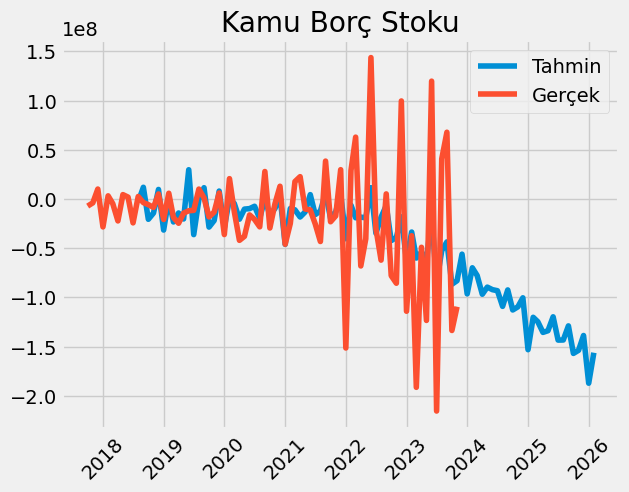

In [92]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][150:],label="Tahmin")
plt.plot(borc["Borç"][140:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [93]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(27)
borctahmin

ds
2023-11-30   -32.495882
2023-12-31    72.112996
2024-01-31   -27.506773
2024-02-29    11.234788
2024-03-31    24.505891
2024-04-30    -7.493899
2024-05-31     2.893505
2024-06-30     1.148269
2024-07-31    17.078192
2024-08-31   -15.319382
2024-09-30    22.054869
2024-10-31    -2.840899
2024-11-30    -8.370352
2024-12-31    52.561705
2025-01-31   -21.511966
2025-02-28     3.786501
2025-03-31     8.656308
2025-04-30    -1.259595
2025-05-31   -10.563713
2025-06-30    19.786732
2025-07-31    -0.070525
2025-08-31   -10.022344
2025-09-30    21.707109
2025-10-31    -2.012147
2025-11-30    -9.783155
2025-12-31    34.979928
2026-01-31   -16.565977
Name: yhat, dtype: float64

In [94]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-11-30", end="2026-02-27", freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-07-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-07-31,4.084417e+07
2023-08-31,6.792059e+07
2023-09-30,-1.335512e+08
2023-10-31,-1.093808e+08
2023-11-30,-7.383654e+07
2023-12-31,-1.270823e+08
2024-01-31,-9.212605e+07
2024-02-29,-1.024762e+08
2024-03-31,-1.275889e+08
2024-04-30,-1.180275e+08


In [95]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [96]:
#study.best_params

In [97]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"].index
sn["y"]=df3["Kredi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=7.34998226814572,
 changepoint_range=0.9866543753451638,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:55 - cmdstanpy - INFO - Chain [1] start processing
22:25:55 - cmdstanpy - INFO - Chain [1] done processing


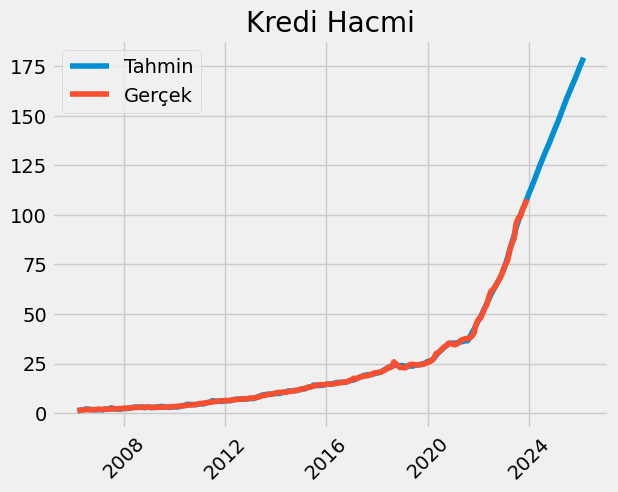

In [98]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df3["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [99]:
kreditahmin=predictions["yhat"].tail(30)
kreditahmin[:3]=df3.iloc[-3:,0]
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi"]
kreditahmin=kreditahmin.set_index(pd.date_range(start="2023-09-30",periods=len(kreditahmin),freq="1M"))
kreditahmin

,Kredi
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144
2023-12-31,110.747146
2024-01-31,113.266284
2024-02-29,115.774377
2024-03-31,118.535650
2024-04-30,121.435407
2024-05-31,124.332913
2024-06-30,126.841730


In [100]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"].index
    sn["y"]=m3["M3 Para Arzi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"].index\n    sn["y"]=m3["M3 Para Arzi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [101]:
#study.best_params

In [102]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"].index
sn["y"]=m3["M3 Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=8.349018793181163,
 changepoint_range=0.9998797288182553,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:56 - cmdstanpy - INFO - Chain [1] start processing
22:25:56 - cmdstanpy - INFO - Chain [1] done processing


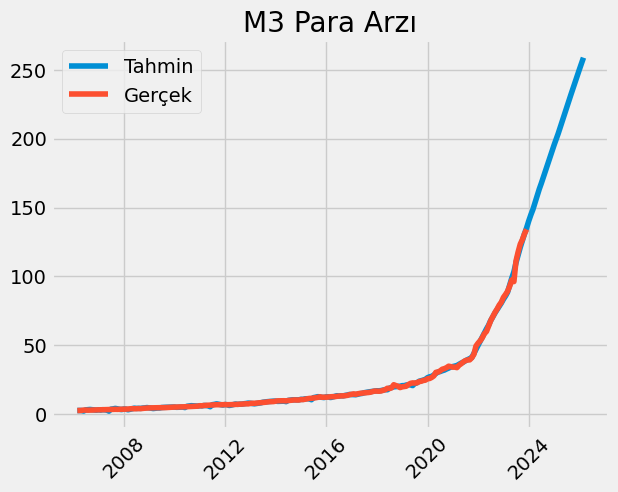

In [103]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(m3["M3 Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [104]:
m3tahmin=predictions["yhat"].tail(30)
m3tahmin[:3]=m3.iloc[-3:,0]
m3tahmin=pd.DataFrame(m3tahmin)
m3tahmin.columns=["M3"]
m3tahmin=m3tahmin.set_index(pd.date_range(start="2023-09-30",periods=len(kreditahmin),freq="1M"))
m3tahmin

,M3
2023-09-30,126.660411
2023-10-31,130.933903
2023-11-30,134.158381
2023-12-31,140.232633
2024-01-31,144.721396
2024-02-29,148.516007
2024-03-31,153.448476
2024-04-30,158.312950
2024-05-31,163.354211
2024-06-30,167.601338


In [105]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [106]:
#study.best_params

In [107]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=9.211536170339631,
 changepoint_range=0.891187110790083,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:56 - cmdstanpy - INFO - Chain [1] start processing
22:25:57 - cmdstanpy - INFO - Chain [1] done processing


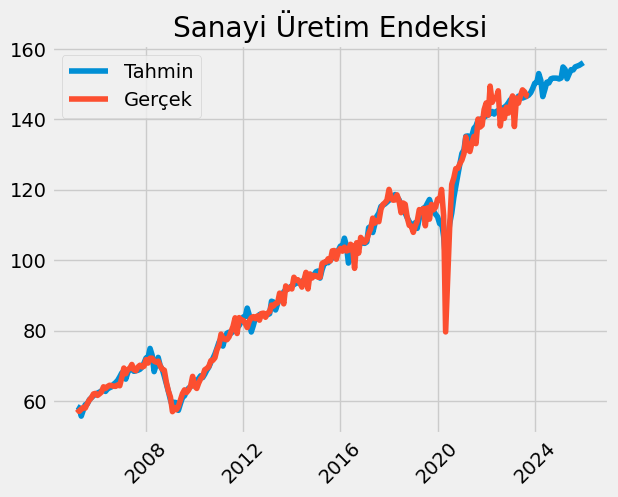

In [108]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [109]:
sanayitahmin=predictions["yhat"].tail(27)
sanayitahmin=pd.DataFrame(sanayitahmin)
sanayitahmin.columns=["Sanayi"]
sanayitahmin=sanayitahmin.set_index(pd.date_range(start="2023-10-31",periods=len(sanayitahmin),freq="1M"))
sanayitahmin

,Sanayi
2023-10-31,147.549780
2023-11-30,148.746355
2023-12-31,150.218248
2024-01-31,150.476348
2024-02-29,152.980863
2024-03-31,151.088129
2024-04-30,146.446123
2024-05-31,148.435360
2024-06-30,150.541376
2024-07-31,150.307142


In [110]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [111]:
#study.best_params

In [112]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=200
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=200
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:57 - cmdstanpy - INFO - Chain [1] start processing
22:25:58 - cmdstanpy - INFO - Chain [1] done processing


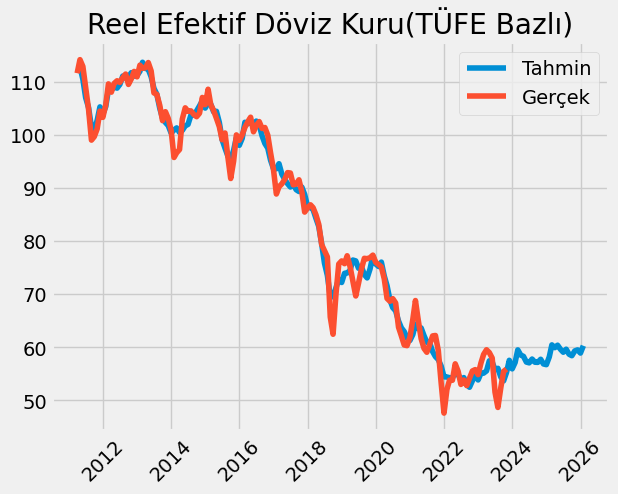

In [113]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [114]:
redkttahmin=predictions["yhat"].tail(28)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-10-31",periods=len(redkttahmin),freq="1M"))
redkttahmin

,REDKT
2023-10-31,55.257962
2023-11-30,57.555282
2023-12-31,55.948002
2024-01-31,57.130925
2024-02-29,59.515766
2024-03-31,58.554731
2024-04-30,58.294568
2024-05-31,57.222623
2024-06-30,57.077329
2024-07-31,57.795543


In [115]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic','linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\',\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [116]:
#study.best_params

In [117]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
sn["cap"]=165
prophet=Prophet(changepoint_prior_scale=4.697452368413781,
 changepoint_range=0.9845493532029166,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=165
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:59 - cmdstanpy - INFO - Chain [1] done processing


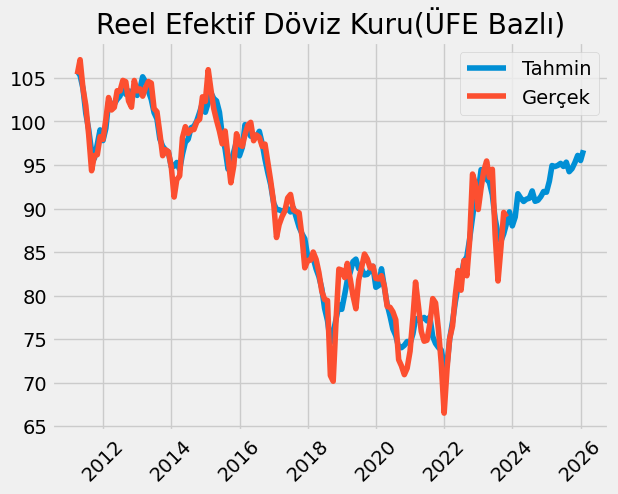

In [118]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [119]:
redktahmin=predictions["yhat"].tail(28)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-10-31",periods=len(redkttahmin),freq="1M"))
redktahmin

,REDK
2023-10-31,88.331233
2023-11-30,89.614913
2023-12-31,88.006828
2024-01-31,89.026586
2024-02-29,91.698703
2024-03-31,91.184517
2024-04-30,90.812384
2024-05-31,91.083325
2024-06-30,91.176576
2024-07-31,92.020389


In [156]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),paraarzitahmin1["Para Arzi"].shift(1),sanayitahmin["Sanayi"],kreditahmin.rolling(2).mean(),redkttahmin["REDKT"],redktahmin["REDK"],m3tahmin.shift(1),borctahmin1.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende"]=perakendetahmin



tahmindf["Şok"]=0

tahmindf=tahmindf[['USD/TL', 'Motorin','Perakende', 'Kredi Faizi', 'Zam','Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','Şok','M3','REDKT','REDK','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Perakende Satış","Kredi Faizi","Zam","Sanayi","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Şok','M3','REDKT','REDK','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)
#tahmindf.iloc[0,10]=45.17
tahmindf=tahmindf.iloc[:15]
tahmindf.iloc[:,-1]=[36,40,42.5,45,45,45,45,45,45,45,45,45,45,42.5,40]
tahmindf.iloc[0,13:15]=[0.60,-0.30]
tahmindf

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Şok,M3,REDKT,REDK,İşsizlik,Politika Faizi
2023-11-30,2.001541,-3.136247,1.033406,58.655000,0.0,0.810964,4.490000,3.356285,-18.098254,2.547674,45.667500,0,3.373976,0.600000,-0.300000,9.020789,36.0
2023-12-31,2.872234,-4.039005,5.092513,58.050804,0.0,0.989532,4.802205,2.361427,-32.495882,2.799611,46.895208,0,2.462676,-2.792584,-1.794439,9.037068,40.0
2024-01-31,2.953012,-0.348001,1.614187,58.243736,45.0,0.171816,5.029205,2.435868,72.112996,2.470179,48.122917,0,4.527672,2.114326,1.158725,9.070009,42.5
2024-02-29,2.416705,3.118655,5.821133,58.551302,0.0,1.664391,4.548808,2.899538,-27.506773,2.244165,49.350625,0,3.200941,4.174343,3.001482,9.105404,45.0
2024-03-31,2.620643,0.323235,1.644104,59.409785,0.0,-1.237236,4.443607,2.177861,11.234788,2.300625,50.578333,0,2.622011,-1.614757,-0.560734,9.162471,45.0
2024-04-30,2.600725,4.178264,-10.673696,60.386403,0.0,-3.072383,4.622889,2.761391,24.505891,2.416042,51.806042,0,3.321170,-0.444307,-0.408110,9.217564,45.0
2024-05-31,3.251032,7.069784,-1.121014,60.370085,0.0,1.358340,4.410014,2.752941,-7.493899,2.415818,53.033750,0,3.170103,-1.838843,0.298353,9.272508,45.0
2024-06-30,3.031501,7.077557,10.832184,61.813906,0.0,1.418810,4.388893,2.824177,2.893505,2.199764,54.261458,0,3.184364,-0.253909,0.102379,9.325146,45.0
2024-07-31,2.772477,-0.341210,0.895907,62.228177,0.0,-0.155594,4.233606,2.229595,1.148269,2.072975,55.489167,0,2.599950,1.258318,0.925472,9.375390,45.0
2024-08-31,2.696319,3.100021,-1.028484,62.126429,0.0,0.790256,4.137704,2.454751,17.078192,2.092721,56.716875,0,2.797617,-1.043743,-1.293000,9.423861,45.0


In [121]:
cor_matrix=data.corr()


In [122]:
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.724721
Motorin                   0.718312
ParaArzi                  0.678612
M3                        0.670119
Enflasyon Belirsizliği    0.622137
Kredi Faizi               0.531337
Kredi                     0.520359
Şok                       0.449432
Mevduat Faizi             0.441591
Zam                       0.410035
Politika Faizi            0.215310
REDK                     -0.000213
REDKT                    -0.024862
Sanayi                   -0.047965
Perakende Satış          -0.116436
İşsizlik                 -0.187390
Borç                     -0.199657
Name: TÜFE, dtype: float64

In [157]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1749.04
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-11-30,1785.138752
2023-12-31,1814.121820
2024-01-31,1898.410419
2024-02-29,1949.166683
2024-03-31,1998.896668
2024-04-30,2086.255574
2024-05-31,2168.617782
2024-06-30,2230.086034
2024-07-31,2286.102858
2024-08-31,2360.083947


In [158]:
features=['Motorin', 'USD/TL','ParaArzi','Enflasyon Belirsizliği','Kredi Faizi','Kredi','Zam']


X= data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1749.04
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-11-30,1791.590999
2023-12-31,1834.343218
2024-01-31,1922.032127
2024-02-29,1981.187644
2024-03-31,2035.236754
2024-04-30,2101.369403
2024-05-31,2177.457677
2024-06-30,2256.394095
2024-07-31,2318.011141
2024-08-31,2389.332434


In [159]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Politika Faizi']


X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfetahmin5 = []
result = 1749.04
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-11-30,1782.363407
2023-12-31,1809.332255
2024-01-31,1889.647583
2024-02-29,1938.041750
2024-03-31,1984.936918
2024-04-30,2065.767186
2024-05-31,2143.006918
2024-06-30,2203.511326
2024-07-31,2255.532069
2024-08-31,2324.185198


In [160]:
features=['USD/TL','Motorin','Enflasyon Belirsizliği','ParaArzi','M3','Kredi Faizi','Zam']



X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1749.04
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-11-30,1793.655497
2023-12-31,1837.919734
2024-01-31,1914.496821
2024-02-29,1973.489312
2024-03-31,2026.491612
2024-04-30,2090.648724
2024-05-31,2165.552756
2024-06-30,2243.767235
2024-07-31,2304.852357
2024-08-31,2375.771443


In [161]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği',  'Politika Faizi']

X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1749.04
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-11-30,1792.543927
2023-12-31,1829.509338
2024-01-31,1922.703586
2024-02-29,1982.747748
2024-03-31,2042.461382
2024-04-30,2140.975372
2024-05-31,2235.396136
2024-06-30,2309.497782
2024-07-31,2379.237374
2024-08-31,2468.145472


In [162]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'İşsizlik', 'Politika Faizi']



X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1749.04  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-11-30,1782.766106
2023-12-31,1808.974086
2024-01-31,1889.859991
2024-02-29,1937.031018
2024-03-31,1983.204011
2024-04-30,2066.866169
2024-05-31,2145.155984
2024-06-30,2202.432165
2024-07-31,2254.513924
2024-08-31,2324.190665


In [163]:
features=['USD/TL','Motorin','Enflasyon Belirsizliği','ParaArzi','M3','Kredi Faizi','Zam']
X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-11-30,1795.328163
2023-12-31,1841.680254
2024-01-31,1936.129006
2024-02-29,2000.147247
2024-03-31,2059.485701
2024-04-30,2131.680693
2024-05-31,2214.207742
2024-06-30,2300.193955
2024-07-31,2368.853639
2024-08-31,2447.945228


In [164]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Ortalama
2023-11-30,1785.138752,1791.590999,1782.363407,1793.655497,1792.543927,1782.766106,1795.328163,1789.055265
2023-12-31,1814.121820,1834.343218,1809.332255,1837.919734,1829.509338,1808.974086,1841.680254,1825.125815
2024-01-31,1898.410419,1922.032127,1889.647583,1914.496821,1922.703586,1889.859991,1936.129006,1910.468505
2024-02-29,1949.166683,1981.187644,1938.041750,1973.489312,1982.747748,1937.031018,2000.147247,1965.973057
2024-03-31,1998.896668,2035.236754,1984.936918,2026.491612,2042.461382,1983.204011,2059.485701,2018.673292
2024-04-30,2086.255574,2101.369403,2065.767186,2090.648724,2140.975372,2066.866169,2131.680693,2097.651874
2024-05-31,2168.617782,2177.457677,2143.006918,2165.552756,2235.396136,2145.155984,2214.207742,2178.484999
2024-06-30,2230.086034,2256.394095,2203.511326,2243.767235,2309.497782,2202.432165,2300.193955,2249.411799
2024-07-31,2286.102858,2318.011141,2255.532069,2304.852357,2379.237374,2254.513924,2368.853639,2309.586195
2024-08-31,2360.083947,2389.332434,2324.185198,2375.771443,2468.145472,2324.190665,2447.945228,2384.236341


In [165]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]
'''
dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]'''





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [166]:
row=pd.DataFrame({"SGD Regressor":df.iloc[-1,0],"Lasso Regression":df.iloc[-1,0],"Lars Regression":df.iloc[-1,0],"Gaussian Regression":df.iloc[-1,0],"Kernel Regression":df.iloc[-1,0],"Bayessian Regression":df.iloc[-1,0],"Linear Regression":df.iloc[-1,0],"Ortalama":df.iloc[-1,0]},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin.iloc[1,:7]=tüfetahmin.iloc[1,:7]+22
tüfetahmin.iloc[2,:7]=tüfetahmin.iloc[2,:7]+33
tüfetahmin.iloc[3,:7]=tüfetahmin.iloc[3,:7]+30
tüfetahmin.iloc[4,:7]=tüfetahmin.iloc[4,:7]+30
tüfetahmin.iloc[5,:7]=tüfetahmin.iloc[5,:7]+30
tüfetahmin.iloc[6,:7]=tüfetahmin.iloc[6,:7]+30
tüfetahmin.iloc[7,:7]=tüfetahmin.iloc[7,:7]+30
tüfetahmin.iloc[8,:7]=tüfetahmin.iloc[8,:7]+30
tüfetahmin.iloc[9,:7]=tüfetahmin.iloc[9,:7]+30
tüfetahmin.iloc[10,:7]=tüfetahmin.iloc[10,:7]+30
tüfetahmin.iloc[11,:7]=tüfetahmin.iloc[11,:7]+30
tüfetahmin.iloc[12,:7]=tüfetahmin.iloc[12,:7]+30
tüfetahmin.iloc[13,:7]=tüfetahmin.iloc[13,:7]+30
tüfetahmin.iloc[14,:7]=tüfetahmin.iloc[14,:7]+30
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,Ortalama
2023-10-31,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000
2023-11-30,1807.138752,1804.363407,1815.655497,1804.766106,1814.543927,1817.328163,1813.590999,1808.305265
2023-12-31,1847.121820,1842.332255,1870.919734,1841.974086,1862.509338,1874.680254,1867.343218,1854.000815
2024-01-31,1928.410419,1919.647583,1944.496821,1919.859991,1952.703586,1966.129006,1952.032127,1936.718505
2024-02-29,1979.166683,1968.041750,2003.489312,1967.031018,2012.747748,2030.147247,2011.187644,1992.223057
2024-03-31,2028.896668,2014.936918,2056.491612,2013.204011,2072.461382,2089.485701,2065.236754,2044.923292
2024-04-30,2116.255574,2095.767186,2120.648724,2096.866169,2170.975372,2161.680693,2131.369403,2123.901874
2024-05-31,2198.617782,2173.006918,2195.552756,2175.155984,2265.396136,2244.207742,2207.457677,2204.734999
2024-06-30,2260.086034,2233.511326,2273.767235,2232.432165,2339.497782,2330.193955,2286.394095,2275.661799
2024-07-31,2316.102858,2285.532069,2334.852357,2284.513924,2409.237374,2398.853639,2348.011141,2335.836195


In [167]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,Ortalama
2023-11-30,3.317616,3.158944,3.804535,3.181967,3.740984,3.900164,3.686503,3.384308
2023-12-31,2.212507,2.104279,3.043762,2.061651,2.643387,3.155847,2.963856,2.526982
2024-01-31,4.400825,4.196601,3.932669,4.228393,4.842620,4.878099,4.535262,4.461578
2024-02-29,2.632026,2.520992,3.033818,2.457004,3.074925,3.256055,3.030458,2.865907
2024-03-31,2.512673,2.382834,2.645500,2.347344,2.966772,2.922865,2.687423,2.645298
2024-04-30,4.305735,4.011553,3.119736,4.155672,4.753478,3.455156,3.202182,3.862178
2024-05-31,3.891884,3.685511,3.532128,3.733658,4.349232,3.817726,3.569924,3.805879
2024-06-30,2.795768,2.784363,3.562405,2.633199,3.271024,3.831473,3.575897,3.217022
2024-07-31,2.478526,2.329101,2.686516,2.332960,2.980964,2.946522,2.694944,2.644259
2024-08-31,3.194206,3.003814,3.037412,3.049959,3.690300,3.297058,3.037519,3.195864


In [168]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin10.columns=["CPI"]


tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [169]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [170]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [171]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [172]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [173]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [174]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [175]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [176]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":3.43},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)
aylık.to_csv('aylık.csv')

In [178]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
aylık1=aylık1.set_index(pd.date_range(start="2014-01-31",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

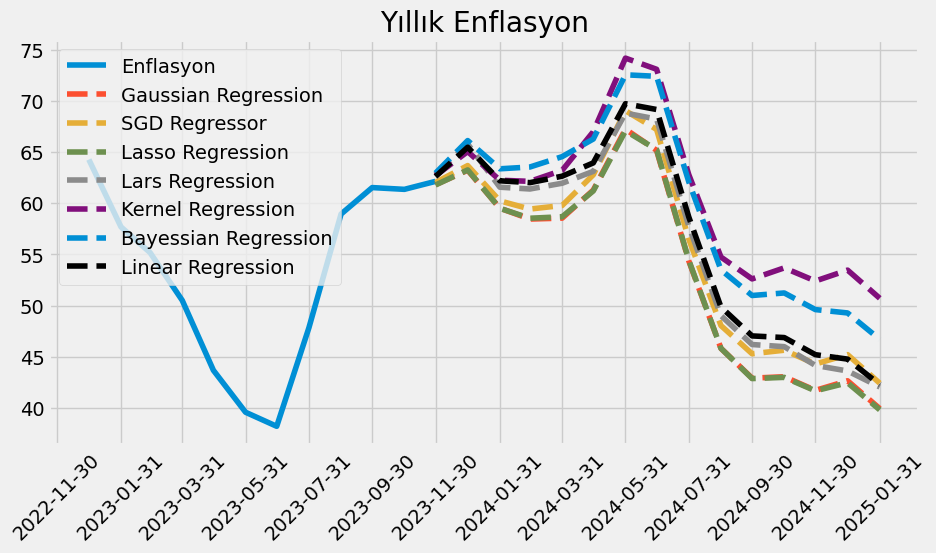

In [180]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:],'--',label="Bayessian Regression")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:],'--',label="Linear Regression",color="black")
plt.legend(loc=0)
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2022-11-30",end="2025-02-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [181]:

df.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/df.csv')

In [199]:
yıllıktahmin["Maksimum"]=yıllıktahmin.iloc[:,1:8].max(axis=1)
yıllıktahmin["Minimum"]=yıllıktahmin.iloc[:,1:8].min(axis=1)
yıllıktahmin.iloc[11:-1].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin

,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,Maksimum,Minimum
2021-12-31,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494


In [192]:
sonu2023=str(yıllıktahmin.iloc[24,0])[:5]
tepe=str(yıllıktahmin.iloc[29,0])[:5]
sonu2024=str(yıllıktahmin.iloc[36,0])[:5]
max=str(yıllıktahmin.iloc[36,-2])[:5]
min=str(yıllıktahmin.iloc[36,-1])[:5]


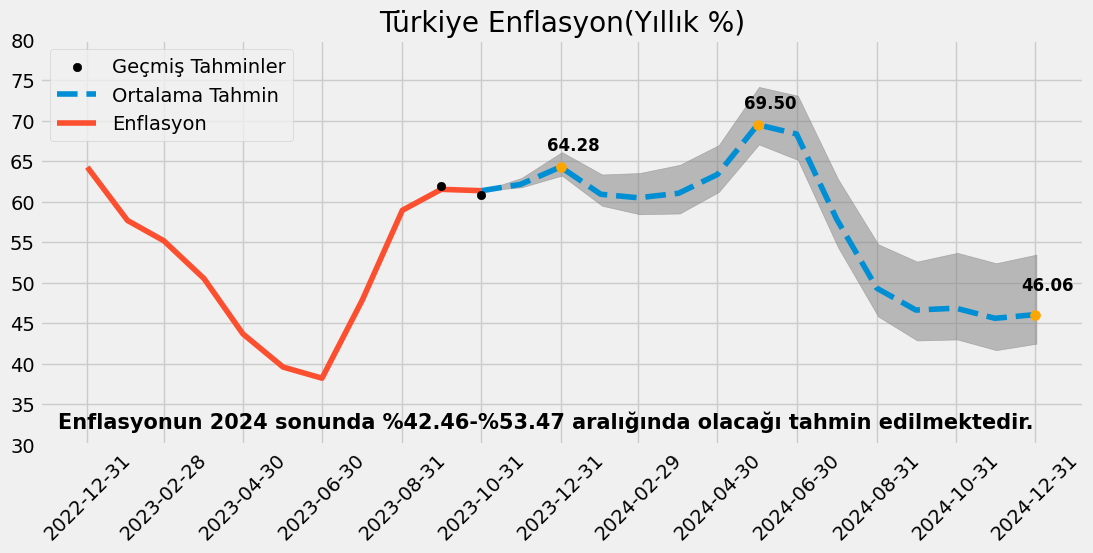

In [194]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(12,5))
plt.scatter(x=yıllıktahmin.index[21:23],y=[61.94,60.84],color='black',zorder=3,label='Geçmiş Tahminler')
plt.scatter(x=yıllıktahmin.index[24],y=yıllıktahmin.iloc[24,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[29],y=yıllıktahmin.iloc[29,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[22:37],'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[12:23],label="Enflasyon")
plt.fill_between(yıllıktahmin.iloc[22:39].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[22:39].shift(1), yıllıktahmin["Minimum"].iloc[22:39].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2024-12')
plt.text(mdates.datestr2num('2024-01'), float(sonu2023)+2, sonu2023, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+2, tepe, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+3, sonu2024, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min}-%{max} aralığında olacağı tahmin edilmektedir.", fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[12:38:2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()
